# Modeling Personal Loan Delinquency with LendingClub Data

## Background

The domain of our project is peer-to-peer consumer lending. Our goal is to model credit risk on personal loans, more precisely to evaluate the probability of default or delinquency of borrowers throughout their loan term.

LendingClub loans are made over either a 36 or 60 month term, with a variety of statistics reported about each unique loan on a monthly basis (our analysis focuses on the 36 month terms). Our variable of interest is called `loan_status` which has eight possible states. We attempt to model credit risk by estimating the probability of a loan transitioning between any two of these states at any month during the loan term. Below are the eight `loan_status` states, with descriptions from LendingClub's [website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):

- **Current**: Loan is up to date on all outstanding payments. 

- **In Grace Period**: Loan payment is late, but within the 15-day grace period.
 
- **Late (16-30)**: Loan is late, past the grace period, hasn't been current for 16 to 30 days.
 
- **Late (31-120)**: Loan has not been current for 31 to 120 days.
 
- **Charged Off**: Loan for which there is no longer a reasonable expectation of further payments. Charge Off typically occurs when a loan is 120 days or more past due and there is no reasonable expectation of sufficient payment to prevent the charge off. Loans for which borrowers have filed for bankruptcy may be charged off earlier.

- **Default**: Loan has not been current for an extended period of time. Charged off and default states are similar, yet different. [TODO explain]

- **Fully paid**: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

- **Done**: Additional state that we add for loans that finish before their term (Either fully paid or delinquent). See the section "Data".

## Markov Chains

To model the transition states month over month, we employed a stationary discrete time step Markov Chain model. Discrete because our data is on a monthly basis, and stationary because we assume the probability distribution of  transition is independent of time (we use the same model across all month). Recall the Markov property, or the "memoryless" assumption, that for some sequence of events, that the conditional probability of the next time step $x_t$ depends only upon the previous time step $x_{t-1}$, ignoring all time steps that preceded it:

$$
\begin{align*}
p(X_t = x_t | X_{t-1} = x_{t-1}, X_{t-2} = x_{t-2}, ... , X_0 = x_0) = p(X_t = x_t | X_{t-1})
\end{align*}
$$

For a discrete time Markov Chain, the joint distribution for the probability of some sequence length $T$ can then be written as:

$$
\begin{align*}
p(X_{1:T}) = p(X_1)p(X_2 | X_1) p(X_3 | X_2) ... = p(X_1)\prod_{t=2}^{T}p(X_t | X_{t-1})
\end{align*}
$$

[Murphy, 2012, p. 589](#References)

For $K$ outcome states, the conditional distribution $p(X_t | X_{t-1})$ can be written as a $K \times K$ transition matrix (denoted $A$) where $A_{jk}  = p(X_t = k | X_{t-1} = j)$ (the probability of transitioning from state $j$ to state $k$, where each row in the matrix can be thought of as an individual probability mass). In our case $K=8$ and we have an $8 \times 8$ transition matrix. The goal of our analysis, then, is to estimate the posterior probabilities of this transition matrix using observed data.

## Data

Our dataset consists of approximately 40 million observations from loans spanning between 2007 through Q3 2018. The dataset includes dozens of fields, however for our Markov model (and to simplify data management) we only need to work with 4 features: `id`, `loan_status`, `term`, and `age_of_loan`.

During preprocessing, we also filtered out all loans with a 60 month term, and 36 term loans that extended beyond 36 months, reducing our dataset to around 27 million observations. In total, we have just under 1.5 million unique loans, which can be seen in the rows column after we split and pivot our data below.

One last preprocessing step that we performed is to extend all loans that are shorter than 36 months to exactly 36 months: The reason is that (given the current version of Edward and Tensorflow), it is not technically possible to build variable length Markov Chains. To do that, all loans that finish earlier than 36 months enter a state "Done" that we created. Note that this is not needed for *Experiment 1*, yet, for consistency, we used that method accross all experiments. To confirm that this extra preprocessing step didn't modify the model too much, we did run *Experiment 1* with and without that step, and found out that the MLE estimates were roughly the same, therefore this step is reasonable.

In [1]:
from utils.utils import (
    load_dataframe, 
    preprocess, 
    split_data, 
    get_counts_per_month
)
from utils.models import (
    build_mle_matrix, 
    model_stationary_dirichlet_categorical_edward, 
    model_stationary_dirichlet_categorical_tfp, 
    model_non_stationary_dirichlet_categorical,
    model_stationary_dirichlet_multinomial
)

from utils.inference import (
    compute_mle, 
    infer_stationary_dirichlet_categorical_edward, 
    infer_stationary_dirichlet_categorical_tfp, 
    infer_non_stationary_dirichlet_categorical, 
    infer_stationary_dirichlet_multinomial
)

from utils.criticism import (
    sample_mle, 
    sample_and_plot_length, 
    graph_trajectory, 
    plot_probs_from_state_j,
    copy_model_ed,
    sample_ed,
    sample_and_plot_length_ed,
    copy_model_tfp,
    sample_tfp,
    sample_and_plot_length_tfp,
)

import edward as ed
import tensorflow as tf

In [2]:
df = load_dataframe()

Loading raw data from cache...
Retrieved 40,219,838 rows, 4 columns in 3.62 seconds


In [3]:
df = preprocess(df)

Mapping column names...
Loading preprocessed data from cache...
Retrieved 27,602,069 rows, 4 columns in 1.30 seconds


In [4]:
x_train, x_test = split_data(df)

Loading split data from cache...
Retrieved 1,508,424 rows, 36 columns in 0.51 seconds
Train: (1356972, 36) | Test: (151452, 36)


In [5]:
chain_len = max(df.age_of_loan)
n_states = df.loan_status.unique().shape[0] + 1

## Experiment 1: Maximum Likelihood Estimate Markov Model 

### 1.1 Model

To get some intuition on how to estimate the transition matrix given our training data, $N$, we start with MLE estimation. The MLE solution of a Markov Chain is simply the empirical frequencies of each transition. Formally, the probability of some particular sequence length $T$, with transition matrix $A$ and states $K$ is given by: 

$$ 
\begin{align*}
p(x_{1:T}|\theta) = p(x_1)A(x_1, x_2)...A(x_{T-1}, x_T) 
&= \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x_1 = j)} \prod_{t=2}^{T} \prod_{j=1}^{K} \prod_{k=1}^{K}(A_{jk})^{\mathbb{I}(x_{t-1} = j, x_t = k)}
\end{align*}
$$

It is relatively easy to show that the MLEs for $p_j$ (at state $j$) and $A_{jk}$ (at transition from states $j$ to $k$) are given by the observed frequencies:  
$$ 
\begin{align*}
p_j = \frac{\sum_{i=1}^N\mathbb{I}(x_{i1} = j)}{\sum_{j}\sum_{i=1}^N\mathbb{I}(x_{i1} = j)}
\end{align*}
$$

$$ 
\begin{align*}
A_{jk} = \frac{\sum_{i=1}^N\sum_{t=1}^{T-1} \mathbb{I}(x_{i,t} = j, x_{i,t+1} = k)}{\sum_k\sum_{i=1}^N\sum_{t=1}^{T-1} \mathbb{I}(x_{i,t} = j, x_{i,t+1} = k)}
\end{align*}
$$

[Murphy, 2012, pp. 592–593](#References)

In more colloquial terms, the estimator for $p$ in any given outcome state $j$ is the number of times we observed $j$ at time $t=1$ in our training data, divided by the total number of observations at time $t=1$. Similarly, the estimator for $A$ of transitioning from state $j$ to state $k$ is given by the total number of times we observed a transition from state $j$ to state $k$, divided by the total number of times we observed a transition from state $j$ to any other state. For our purposes, we ignore $p$ and just generate MLE estimates for the transition matrix $A$. Even though we want to solve the problem from a Bayesian perspective, our first experiment with MLEs is relatively easy to obtain and should give us a reasonable baseline to compare other models against.

In [6]:
realized_transitions = build_mle_matrix(x_train)

Loading transitions data from cache...
Retrieved 8 rows, 8 columns in 0.02 seconds


In [7]:
realized_transitions

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
Charged Off,0,0,0,0,0,0,0,124909
Current,690,21999047,1,636273,5250,144170,55857,542199
Default,26029,132,2062,70,0,4,456,24
Fully Paid,0,0,0,7261,9,87,65,510600
In Grace Period,0,252,0,11,20,53,37,5173
Late (16-30 days),4093,29060,0,1853,230,12046,107561,5237
Late (31-120 days),95286,22818,26850,1935,49,2953,299384,11885
Done,0,0,0,0,0,0,0,22838744


Note that `Charged Off` is a "sink" state, therefore there were no observations out of `Charged Off` and we simply filled this column with zeros. The other transition counts represent all observed loan transitions for 36 month term loans between 2007 to Q3 2018. The "Done" state is also an artificially created sink.

### 1.2 Inference

Now that we have built a matrix of the realized state transitions, we use it to compute the MLE estimate of $A_{jk}$ from above, for each combination of $j$ and $k$.

In [8]:
mle = compute_mle(realized_transitions)

In [9]:
mle

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
Charged Off,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Current,0.000030,0.940794,0.000000,0.027210,0.000225,0.006165,0.002389,0.023187
Default,0.904507,0.004587,0.071654,0.002432,0.000000,0.000139,0.015846,0.000834
Fully Paid,0.000000,0.000000,0.000000,0.014017,0.000017,0.000168,0.000125,0.985672
In Grace Period,0.000000,0.045438,0.000000,0.001983,0.003606,0.009556,0.006671,0.932744
Late (16-30 days),0.025568,0.181534,0.000000,0.011575,0.001437,0.075250,0.671920,0.032715
Late (31-120 days),0.206622,0.049480,0.058223,0.004196,0.000106,0.006403,0.649198,0.025772
Done,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


### 1.3 Criticism

#### 1.3.1 Interpreting the estimates

We can see that a lot of the MLE estimates reflect our expectations, for example we can see that:
- A loan which is `Current` is much more likely to stay 'Current' the next month than any other state transition.
- A loan which is in `Default` is much more likely to be `Charged Off` the next month than any other state transition.
- Some states are not reachable from other states, for example once `Charged Off`, a loan cannot go to any other state except Done, because LendingClub shuts down the loan completely.
- Similarly, a loan cannot transition from `Current` to `Late (31-120 days)` (except with a very low probability which is due to how the data is collected), because first it has to go to either `In Grace Period` or `Late (16-30 days)`, since we are measuring data each month.

One problem often observed with MLE estimates for Markov Models is that without enough samples, you may not have observed all the possible states and the transition matrix will show many zero values. A trick to deal with this is called "add-one smoothing" which adds one to all counts before computing the transition probabilities. We initially thought we may have this issue beause some of our transition probabilities are very small. However, since our dataset is very large and the number of states is small, we concluded that we have enough observations that this problem is unlikeley in our case: if a transition has never been observed, we consider that it is not possible, and if the values are very infrequent we believe this is reflective of the true transition probabilties.

#### 1.3.2 Sampling from the posterior predictive

We can now use these estimates to generate some trajectories. We start at `Current` and keep generating transitions for a period of 36 months, except if we reach `Charged Off` or `Fully Paid` which both are essentially a "sink".

**Sample 1**: An example of "good loan" that was paid back quickly.

Even though the trajectory seems likely, we can see that the loan is quite short. We will discuss loan lengths in the next criticisim section.

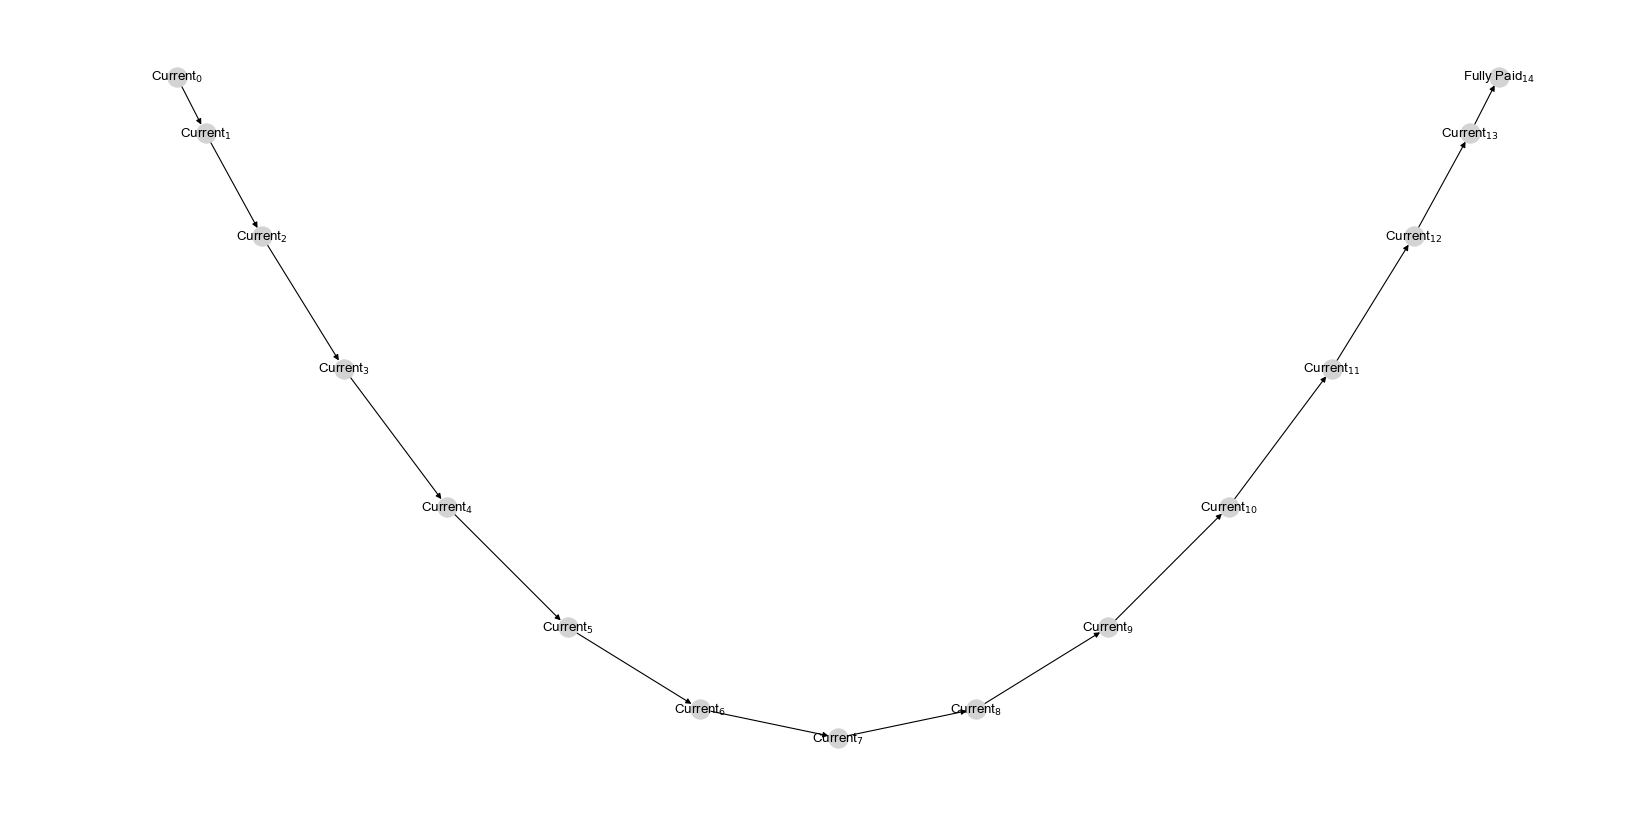

In [15]:
graph_trajectory(sample_mle(mle))

**Sample 2**: An example of "bad loan" that became late after a few months (different states of lateness) until getting charged off in month 12.

We can notice the phenomenon that we mentioned earlier: the transitions `Current` -> `In Grace Period` -> `Late (16-30 days)` -> `Late (31-120 days)` do meet our expectations, yet we can see that the loan only stays one month in the state `Late (31-120 days)` and is `Charged Off` very soon. In reality, we know that the loan would actually stay in that state for at least three months before being `Charged Off`.

This reflects the main drawback of the Markov assumption: the transitions are only conditioned on the current state and do not take into account the previous states, which in our case means that they do not condition on how many months were spent in that state. One way to remedy this would be Higher Order Markov Chain that is conditioned on additional previous states as well—however this was not within the scope of our project.

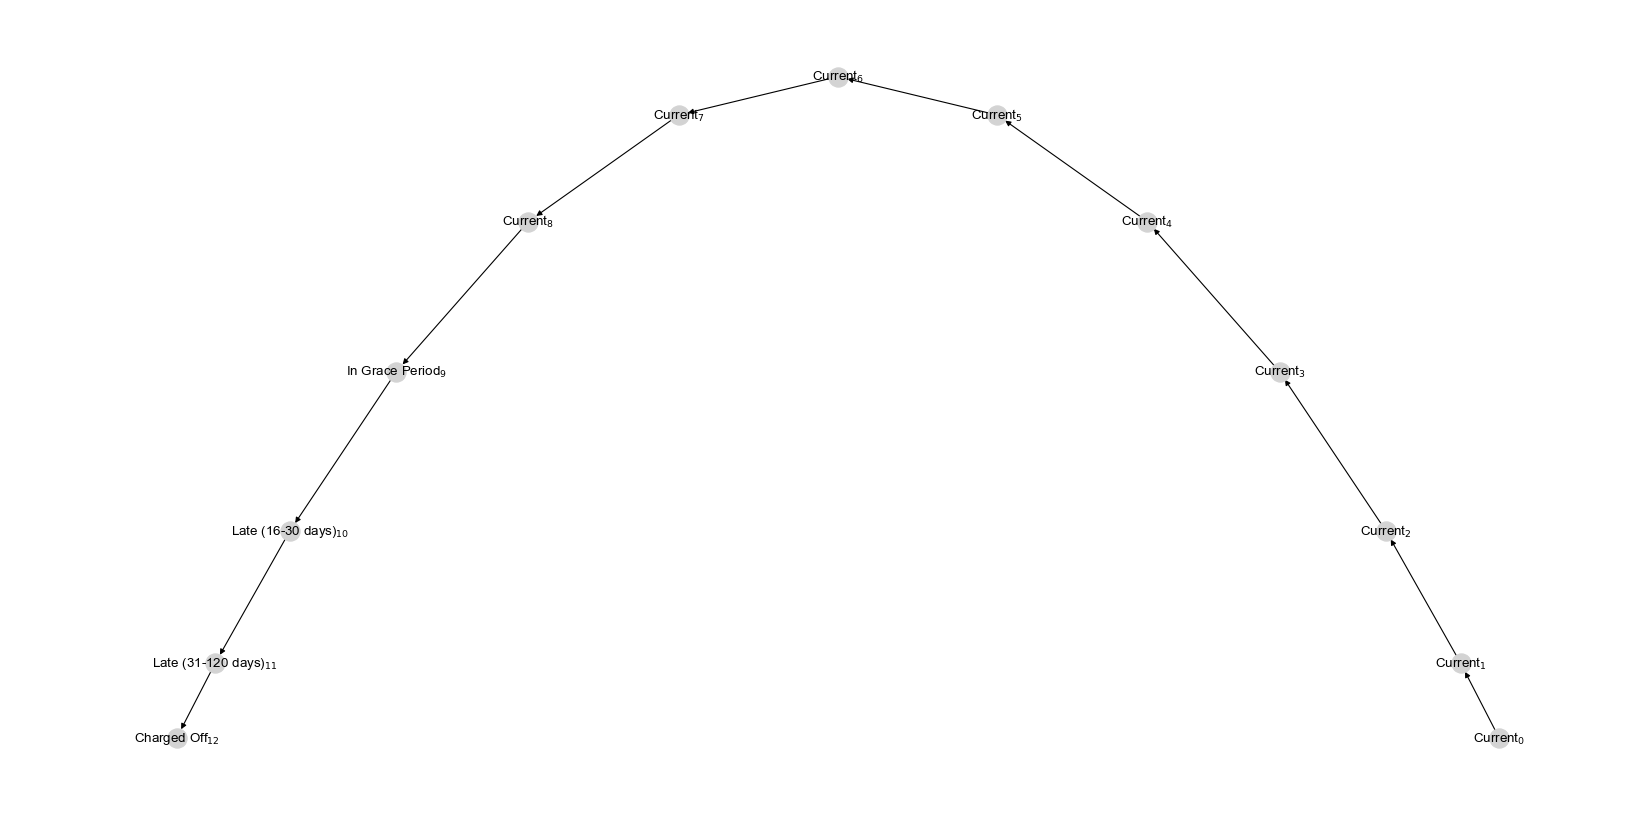

In [18]:
graph_trajectory(sample_mle(mle))

**Sample 3**: A loan that was late but got paid and got back to Current 

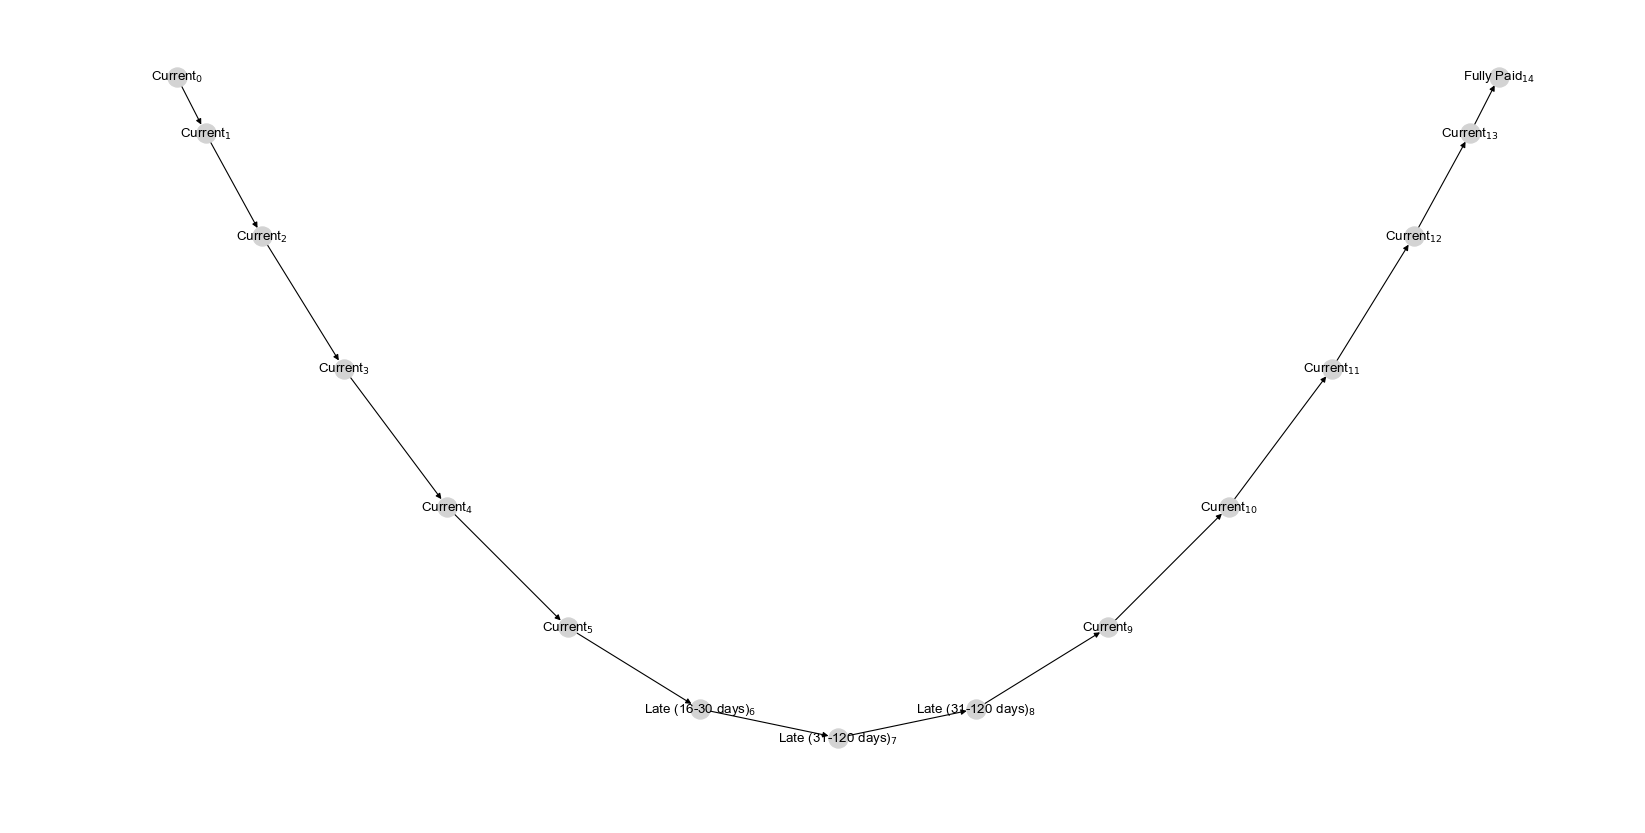

In [14]:
graph_trajectory(sample_mle(mle))

#### 1.3.3 Computing statistics based on generated samples

Since we have the ability to sample from our learned posterior predictive, one interesting analysis that we can do is to look at an interesting test statistic on the real data and on sampled data. This echoes work by [Rubin (1984)](#References) and later [Gelman et al (1996)](#References) presented in Lecture 7

One interesting statistic is the average length of the loans, i.e. after how many months they either reach a delinquency state or are "Fully Paid".

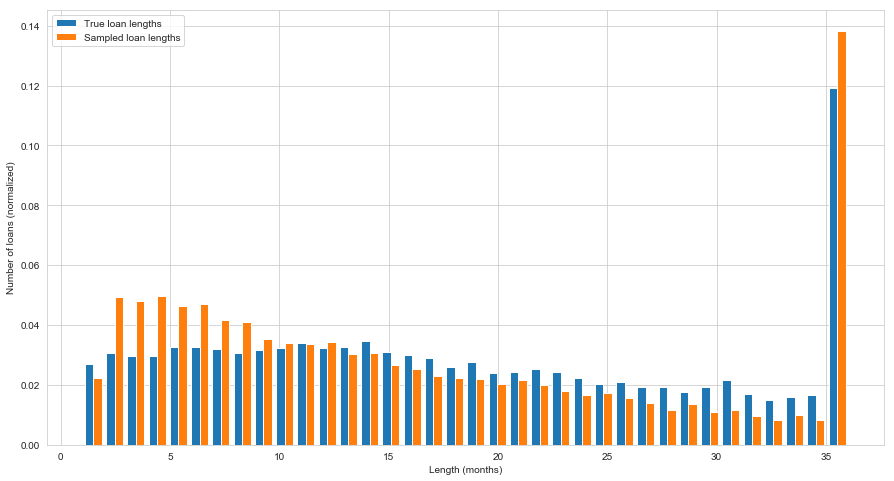

Average length of sampled loans: 16.33 months
Average length of true loans: 18.30 months


In [11]:
sample_and_plot_length(mle, x_train)

We can see on this histogram that the posterior predictive tends to predict shorter loans: in particular, loans shorter than 10 months seem much more likelly. This again shows the main drawback of the Markov assumption: loans that are current have a certain likelihood of moving to a delinquent state that would later cause them to end, which is independent of the age of the loan. Therefore, the model tends to overestimate the probability of delinquency for early months.

## Experiment 2: Stationary Dirichlet-Categorical Markov Model (Edward)

### 2.1 Model

The first Bayesian model we built uses the Categorical Distribution to model state transitions, with the Dirichlet Distribution as priors. 

Recall the Categorical Distribution, denoted Cat$(p_1, ..., p_K)$, is a generalization of the Bernoulli Distribution across outcome states, namely, it describes the possible results of a single trial random variable $X$ that can take on one of $K$ possible outcome states, with the probability of each category given by $(p_1, ..., p_K)$. Recall in our scenario, $K=8$ representing the possible `loan_status` states. The probability mass function is then given by:

$$
\begin{align*}
p(X=x | p_1, ..., p_K) = \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x = j)}
\end{align*}
$$

The Dirichlet Distribution, denoted Dir$(a_1, ..., a_K)$, is the conjugate prior of the Categorical Distribution. It describes the probabilities for a K-dimensional vector of random variables $\bar{X}$ with entries in (0,1) and which sum to 1. It should be clear why this makes sense for modelling our Categorical priors. It is parameterixed by $(a_1, ..., a_K)$, called the concentration paramters, which become hyperparameters in our model. The probability density function is given by:

$$
\begin{align*}
p(\bar{X}=[x_1, ..., x_K] | a_1, ..., a_K) = \frac{\Gamma(\sum_{j=1}^K a_j)}{\prod_{j=1}^K \Gamma(a_j)}\prod_{j=1}^K x_j^{a_j - 1}
\end{align*}
$$

The Markov Chain model we specify for transition matrix $A$, outcome states $K=8$ over sequence of months $T=36$ is given by:

$$
\begin{align*}
x_0 &\text{ ~ Cat}(p_1, ..., p_K) \\
p_0 &\text{ ~ Dir}(a_1, ..., a_K) \\
x_t &\text{ ~ Cat}_{x_{t-1}}(p_1, ..., p_K) \space\space\space\space t \in [1, ..., T] \\
A_j &\text{ ~ Dir}(a_1, ..., a_K) \space\space\space\space j \in [1, ..., K] \\
\end{align*}
$$

Notice that $p_0$ is the Dirichlet for our initial Categorical, and $A_j = [p_1, ..., p_K]$ indicates the $j$th row of the transition matrix, and is not time-dependent since we assume a stationary Markov Chain model with the same transition matrix across time steps. Also note that we are assuming independence of the Categoricals for each $x_t$. These variables represent our likelihoods and our priors. For the Dirichlet-Categorical we can further show that the Dirichlet is a conjugate prior, and therefore we use it to model our posterior distribution as well. Based on the model from 2.1 above, given our dataset $D$, the posterior is given by:

$$
\begin{align*}
p(A_j|D, a_1, ..., a_k) &\propto p(A_j|a_1, ..., a_k)\prod_{x_i \in D} p(x_i | p_1, ..., p_K) \\
&\propto \prod_{j=1}^K p_j^{a_j - 1} \prod_{x_i \in D} \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x_i = j)} \\
&\propto \prod_{j=1}^K p_j^{a_j - 1 + \sum_{x_i \in D}\mathbb{I}(x_i = j)}
\end{align*}
$$

Notice that this derived distribution has the form of a Dirichlet with Dir$(a_1^{'}, ..., a_K^{'})$ where $a_j^{'} = a_j + \sum_{x_i \in D}\mathbb{I}(x_i = j)$

[Tu, 2018](#References)

[Murphy, 2012, p. 594](#References)

In [6]:
batch_size = 1000

In [7]:
x, pi_0, pi_T = model_stationary_dirichlet_categorical_edward(n_states, chain_len, batch_size)

### 2.2 Inference

#### Batch Training

We applied the KLqp variational inference algorithm in Edward to minimize the KL divergence. One caveat while we were implementing the inference function was that due to the size of our dataset, it too a very long time to run. To address this issue, we implemented Edward's [batch training](http://edwardlib.org/tutorials/batch-training) feature, which instead trains the model using only a subsample of data for each update. This significantly reduced training time. We applied the same batch training methodology for all subsequent experiments as well.

#### Parameter tuning

We initialized the priors approximations at random, and different values for parameter tuning, on `n_samples` (used for Monte Carlo estimation in the loss computation), on the `learning_rate`, and on the learning algorithm itself (variants of Gradient Descent). We observed that the training was very sensitive to the learning rate, not only for which value the loss converged too but also too high values of the learning rate made the loss reach `NaN`. Finally, we trained for ... epochs.

We observed that, despite a lot of parameter tuning, the ELBO is quite hard to optimize and the loss keeps oscillating, as shown on the following training curve. Yet, there is some clear dicreasing trend showing that the posterior approximations are indeed slowly converging to the model's posteriors. Nevertheless, one major drawback is that because of this unstable loss, there is no guarantee on the quality of our estimates at the very last iteration of the algorithm.

![Exp 2 loss, intialized at random](resources/exp_2_loss.png)

In [8]:
inferred_qpi, sess, qpi_0, qpi_T = infer_stationary_dirichlet_categorical_edward(
    x_train, x, pi_0, pi_T, n_states, chain_len, batch_size, lr=0.002, n_epoch=20)
inferred_qpi_0 = inferred_qpi[0]
inferred_qpi_T = inferred_qpi[1]

Loading experiment2 data from cache...
Loading cached edward model...
Retrieved data in 0.10 seconds


### 2.3 Criticism

#### 2.3.1 Interpreting the estimates

**TODO** describe

We look at the means of the inferred posteriors, for both the initial distribution (probabilities of the `x_0`) and for the transition matrix:

In [42]:
inferred_qpi_0

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
probs,0.029079,0.758049,0.052101,0.020745,0.053845,0.031751,0.037764,0.016665


In [43]:
inferred_qpi_T

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
Charged Off,0.126364,0.130872,0.105530,0.151373,0.074542,0.091505,0.126446,0.193369
Current,0.023572,0.771536,0.028207,0.053869,0.014999,0.029450,0.023954,0.054413
Default,0.117822,0.114058,0.095189,0.206018,0.059596,0.152124,0.148413,0.106780
Fully Paid,0.109348,0.128055,0.085448,0.171202,0.069363,0.081580,0.128117,0.226889
In Grace Period,0.144683,0.164091,0.101207,0.083340,0.165186,0.111688,0.114226,0.115581
Late (16-30 days),0.144706,0.126425,0.200974,0.055100,0.080785,0.102520,0.129923,0.159569
Late (31-120 days),0.151580,0.137189,0.092395,0.081171,0.120349,0.074567,0.161937,0.180810
Done,0.025881,0.027788,0.023714,0.023678,0.017878,0.027877,0.023554,0.829630


We can see that the mean of the posterior does follow some trends that we observed in the MLE estimate, for example `Current` being more likely when already in `Current`, or `Late (31-120 days)` either staying in that state or transitioning to `Charged Off` both with relatively high probability. Yet, the trends are not as high as expected.

We can also see that the algorithm failed to infer the initial distribution properly, which might have impacted the rest of the inference. We discuss this issue in the very [last section](##Other-experiments,-and-going-further) of our report.

#### 2.3.2 Sampling from the posterior predictive

One drawback of this implementation (compared to the next implementation, Experiment 3) is that we need some custom code to sample correctly from the distribution, which is almost as re-writing the model but for the posterior predictive.

In [9]:
x_0_post, x_post = copy_model_ed(qpi_0, qpi_T, chain_len, n_states, batch_size)

**TODO** describe

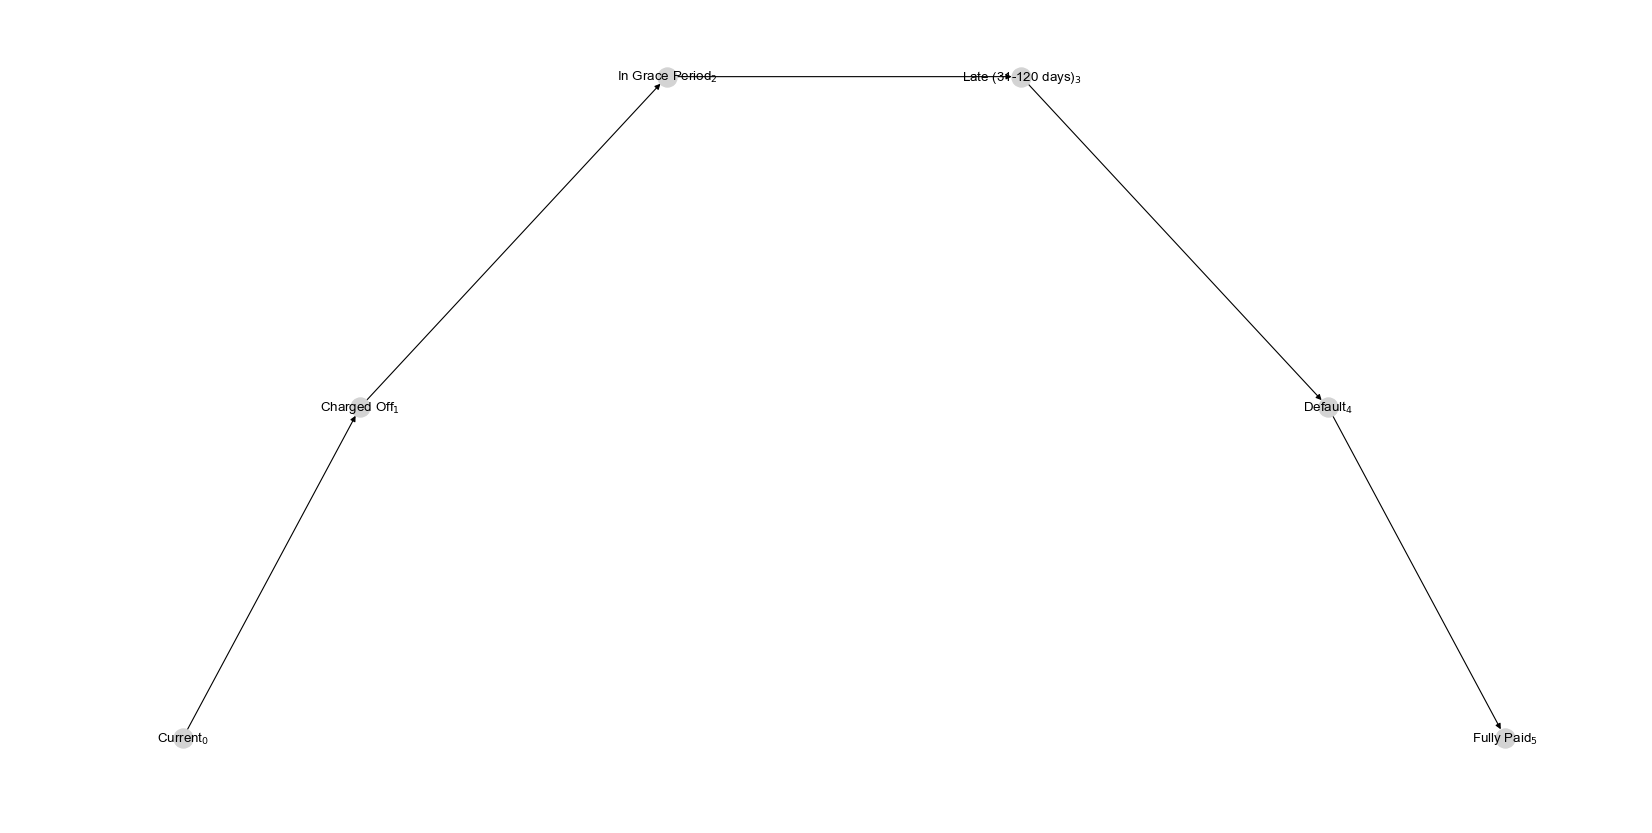

In [13]:
graph_trajectory(sample_ed(x_0_post, x_post, sess, inferred_qpi_0))

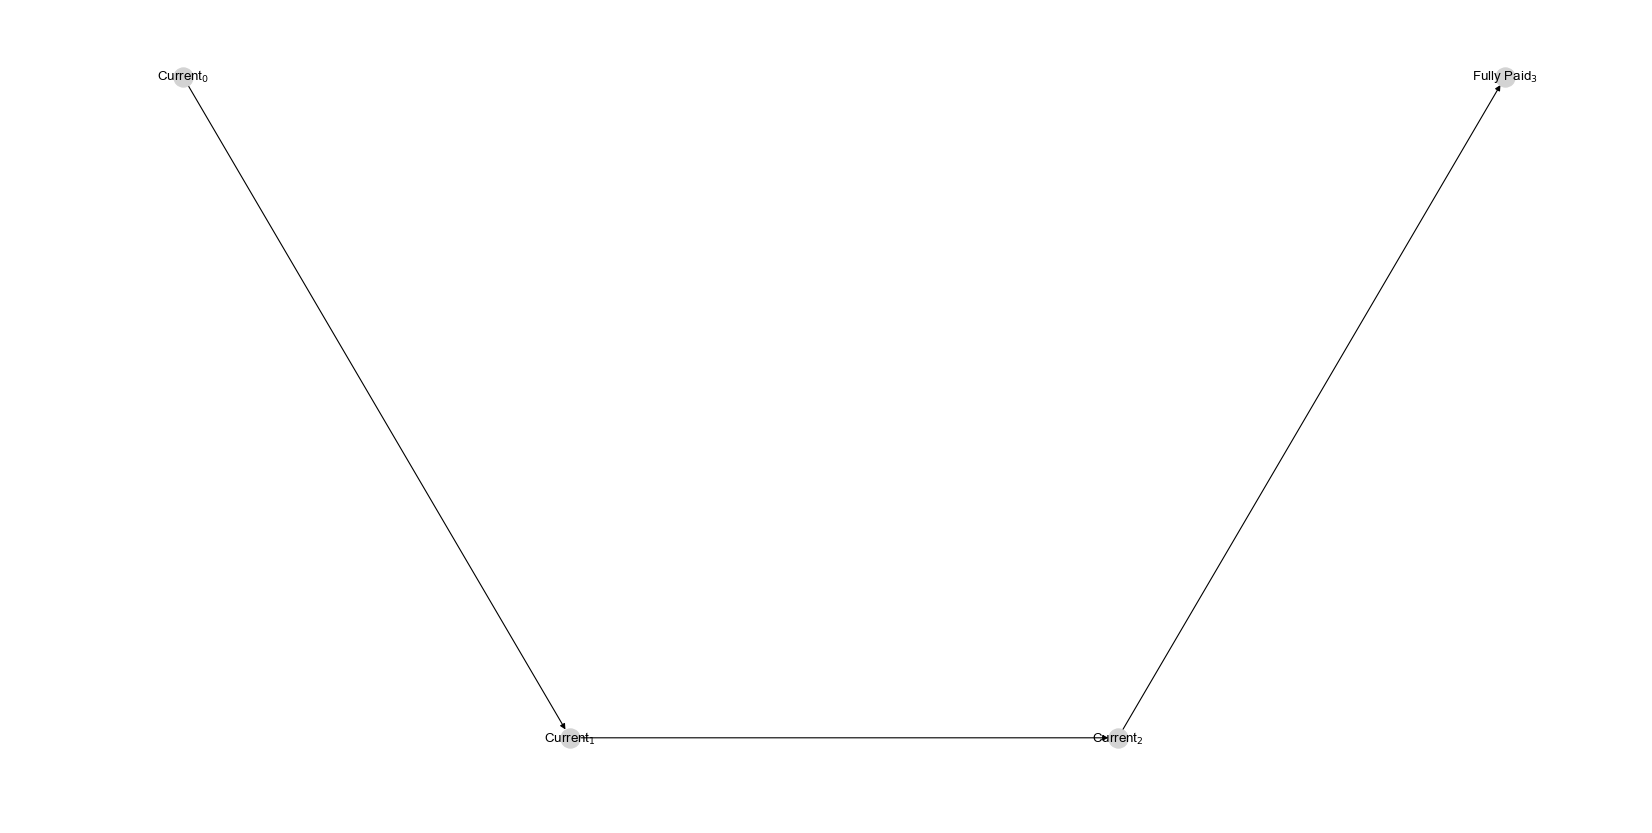

In [15]:
graph_trajectory(sample_ed(x_0_post, x_post, sess, inferred_qpi_0))

#### 3.3.3 Computing statistics based on generated samples

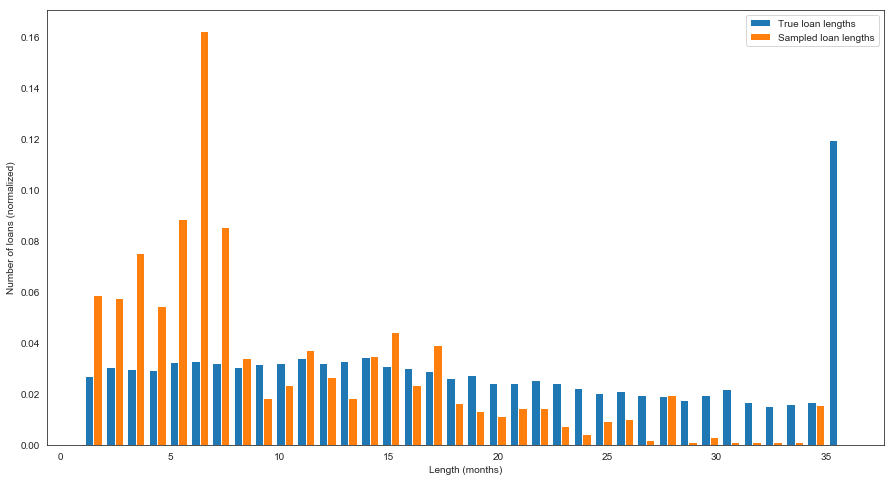

Average length of sampled loans: 9.75 months
Average length of true loans: 18.30 months


In [16]:
sample_and_plot_length_ed(x_0_post, x_post, sess, x_train, inferred_qpi_0)

**TODO** describe

## Experiment 3: Stationary Dirichlet-Categorical Markov Model (Unreleased TFP code)

### 3.1 Model

This experiment is similar to experiment 2 in the sense that we define exactly the same model, yet our implementation is different. Rather than using a list of Categorical Random Variables that share the same prior but implemented "by hand", we define a custom Edward Random Variable, that directly implements the log likelihood of a sequence of observations (instead of deriving it automatically from the graph) and can sample a sequence in one step. We hope that because this model is defined more clearly in Edward/Tensorflow, we might see less variability in our results and hopefully a speed improvement.

Our custom Random Variable code is based on code that has been released on the [Tensorflow Probability repository](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/distributions/hidden_markov_model.py) very recently. Initially, the code is built for a Hidden Markov Model, therefore we use a "trick" by setting its emission distribution to a constant Identity Matrix to use it for our project.

In [9]:
model, pi_0, pi_T = model_stationary_dirichlet_categorical_tfp(
    n_states, chain_len, batch_size=batch_size)

### 3.2 Inference

We started by **initializing the priors at random**, which corresponds to the **blue** training curve below, similarly as Experiment 2, and again observe that the ELBO is very hard to train and oscillates a lot.

In order to smooth the training, we can **initialize the priors with prior knowledge about the model:** we set higher `alpha` values for the Dirichlet priors for the transitions that we know are very likely. As shown in **green**, the loss does decrease but much less than previously, and both methods seem to converge at the same loss value.

Note that we did try these two initialization methods in Experiment 2 too, but the effect was much less visible than in this Experiment.

We also noted that the training is suprisingly much slower than in Experiment 2: In fact, it seems like deriving the KLqp loss for the set of categoricals that we implemented in Experiment 2 is less computationally intensive than using the predefined complete log likelihood and using it to compute the gradients. In our experiments, we train for 5 epochs which takes about 15 minutes. We did train for longer epochs (n_epoch=30) and same parameters and saw no improvement, the loss converges around its current best value.

![Exp 3 loss, intialized with prior knowledge](resources/exp_3_loss.png)

In [10]:
inferred_qpi, sess, qpi_0, qpi_T = infer_stationary_dirichlet_categorical_tfp(
    x_train, model, pi_0, pi_T, n_states, chain_len, batch_size=batch_size,
    lr=0.005, n_epoch=5)

inferred_qpi_0 = inferred_qpi[0]
inferred_qpi_T = inferred_qpi[1]

Loading experiment3 data from cache...
Loading cached edward model...
Retrieved data in 0.07 seconds


### 3.3 Criticism

#### 3.3.1 Interpreting the estimates

We look at the means of the inferred posteriors, for both the initial distribution (probabilities of the `x_0`) and for the transition matrix:

In [9]:
inferred_qpi_0

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
probs,0.159405,0.122083,0.110177,0.157024,0.099248,0.114111,0.159811,0.078141


In [10]:
inferred_qpi_T

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
Charged Off,0.175394,0.167649,0.127722,0.151973,0.082431,0.093290,0.065007,0.136535
Current,0.041731,0.578401,0.052033,0.089443,0.036901,0.075969,0.038981,0.086541
Default,0.108751,0.068371,0.113739,0.063482,0.117682,0.206952,0.092890,0.228133
Fully Paid,0.123663,0.059769,0.112114,0.100985,0.189932,0.072944,0.143112,0.197481
In Grace Period,0.110073,0.193310,0.167544,0.062931,0.090391,0.125587,0.131544,0.118620
Late (16-30 days),0.107183,0.173610,0.111027,0.082505,0.155796,0.137834,0.083230,0.148815
Late (31-120 days),0.181020,0.205464,0.096042,0.056862,0.183738,0.072763,0.141292,0.062819
Done,0.073819,0.036282,0.068117,0.044633,0.048264,0.085935,0.048262,0.594688


We can see that the mean of the posterior does follow some trends that we observed in the MLE estimate, for example `Current` being more likely when already in `Current`, or `Late (31-120 days)` either staying in that state or transitioning to `Charged Off` both with relatively high probability. Yet, the trends are not as high as expected.

We can also see that the algorithm failed to infer the initial distribution properly, which might have impacted the rest of the inference. We discuss this issue in the very [last section](##Other-experiments,-and-going-further) of our report.

#### 3.3.2 Sampling from the posterior predictive

One advantage of this implementation over Experiment 2 is that it handles sampling a complete sequence of observations at once, therefore Edward can automatically integrate out over the posterior to compute the posterior predictive.

We therefore sample directly from the model's sample() method, and then shorten the sequence by stopping when "Done" is reached.

In [11]:
model_post = copy_model_tfp(qpi_0, qpi_T, chain_len, n_states, batch_size)

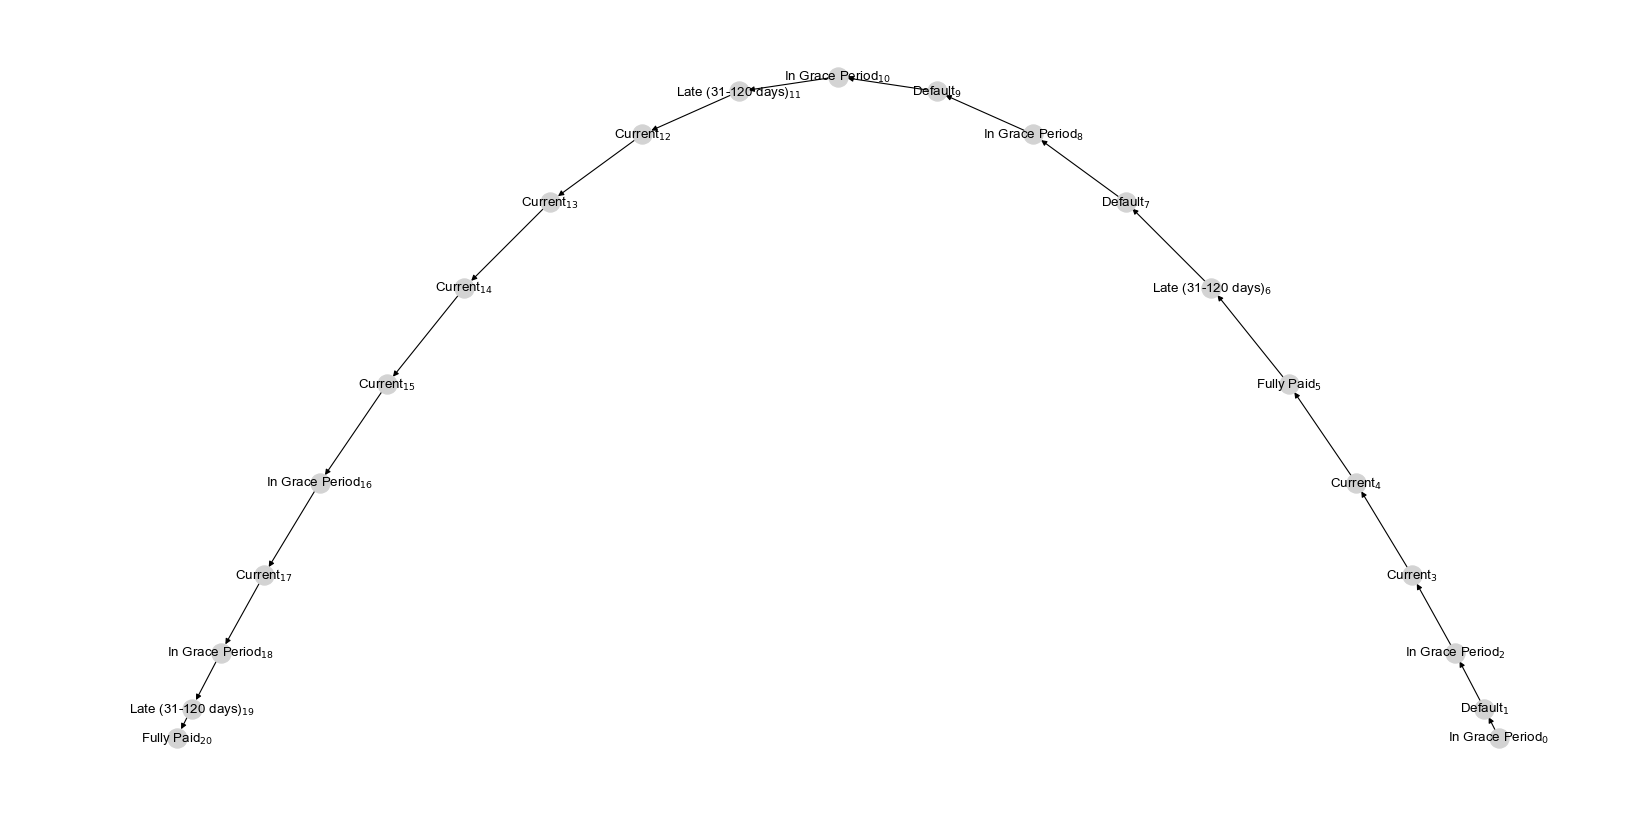

In [39]:
graph_trajectory(sample_tfp(model_post, sess, inferred_qpi_0))

As in Experiment 2, the sampled trajectories seem much less intuitive than results from the MLE for example. In the trajectory above, some transitions are intuitive, for example at month 10, going from Grace Period, to Late, but then back to Current, does actually happen in the dataset quite often. Yet, we got to Grace Period from Default, which is counter-intuitive.

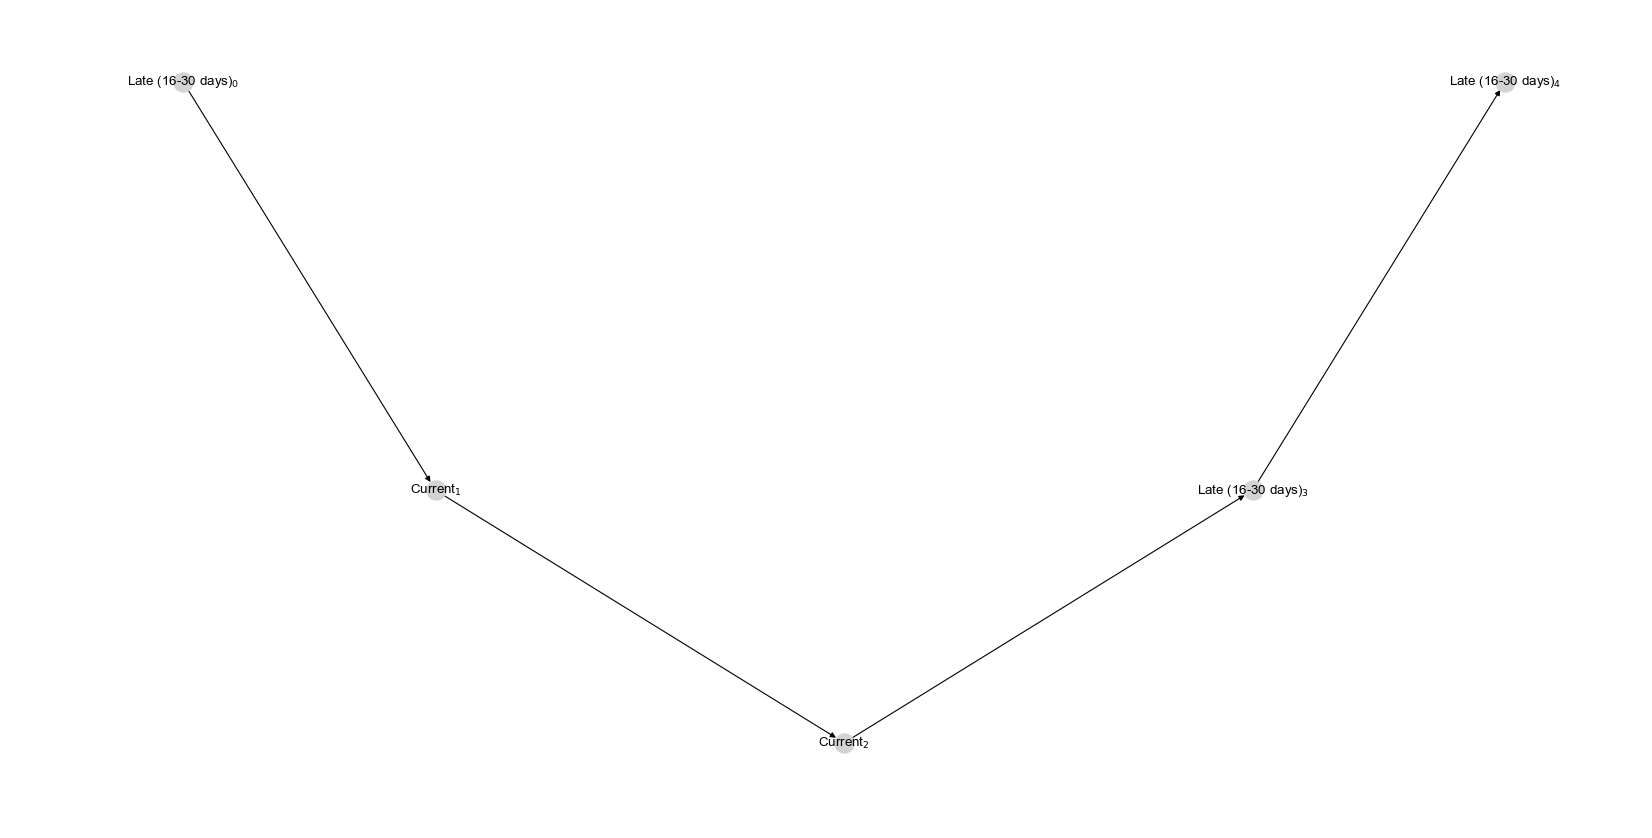

In [26]:
graph_trajectory(sample_tfp(model_post, sess, inferred_qpi_0))

Another issue of the inference is shown in the sample above: since the inferred prior of the initial step's probability is not very good, a lot of samples have trajectories that aren't quite intuitive. Here, for example, the loan starts by already being "Late", which is not supposed to happen.

#### 3.3.3 Computing statistics based on generated samples

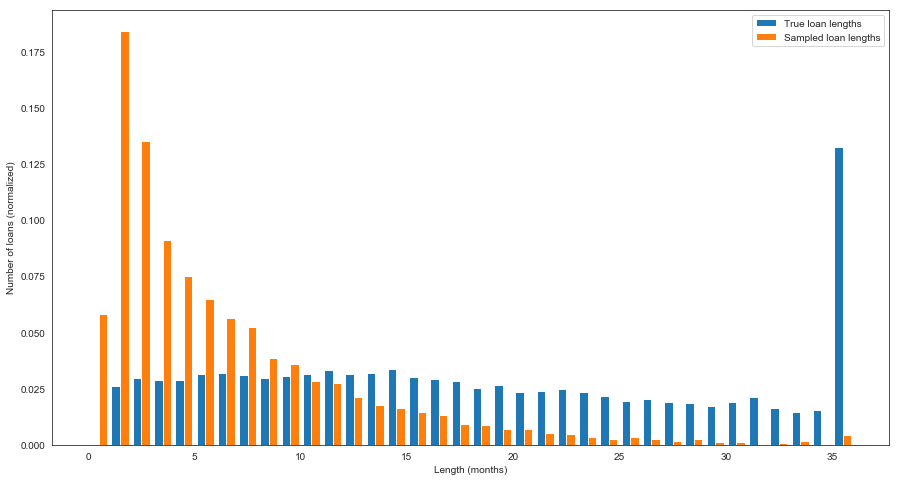

Average length of sampled loans: 5.99 months
Average length of true loans: 18.30 months


In [15]:
sample_and_plot_length_tfp(model_post, sess, x_train, inferred_qpi_0)

Again, we see that the model tends to overestimate the number of short loans, which is due to the model itself and similar to Experiment 1's findings. We also notice that the counts of loans of length 0 is non null and quite high: this is due to the bad inference on the initial step's prior, which generates many samples starting directly in the state "Done". We can re-generate samples by passing a fixed matrix for the probabilities of the initial state, forcing the model to start at state "Current":

In [24]:
probs = tf.constant([0., 1., 0., 0., 0., 0., 0., 0.])
model_post_2 = copy_model_tfp(probs, qpi_T, chain_len, n_states, batch_size)

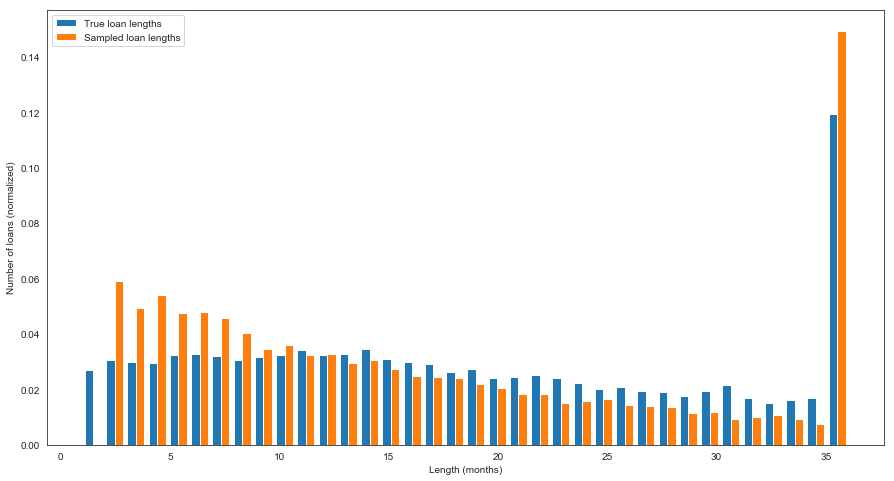

Average length of sampled loans: 16.55 months
Average length of true loans: 18.30 months


In [26]:
sample_and_plot_length_tfp(model_post_2, sess, x_train, inferred_qpi_0)

We see that the average length is closer to its true value, and the issue around length 0 doesn't happen anymore.

## Experiment 4: Non-Stationary Dirichlet-Categorical Markov Model

### 4.1 Model

Instead of each Categorical distribution sharing a single transition matrix across all timesteps, we now create a unique transition matrix for each timestep $(1,...,36)$, with their own respective Dirichlet prior. In other terms, we are now conditioning both on the previous step and on the position in the chain. Our new model can be specified as follows:

The Markov Chain model we specify for transition matrix $A$ (at each row $j$), outcome states $K=8$ over sequence of months $T=36$ is given by:

$$
\begin{align*}
x_0 &\text{ ~ Cat}(p_1, ..., p_K) \\
p_0 &\text{ ~ Dir}(a_1, ..., a_K) \\
x_t &\text{ ~ Cat}_{x_{t-1}}(p_1, ..., p_K) \space\space\space\space t \in [1, ..., T] \\
A_{jt} &\text{ ~ Dir}_{t}(a_1, ..., a_K) \space\space\space\space j \in [1, ..., K], \space\space t \in [1, ..., T]
\end{align*}
$$

This model should capture dynamics of the sequence of transitions better, since we can expect that the probability of different state transitions highly depends on the time elapsed since the beginning of the loan. For instance, it intuitively seems much more likely that a loan will remain `Current` in the next month if it has already been `Current` over 30 months, compared with a loan that has only been `Current` for, say, a single month. 

In [27]:
batch_size = 1000

In [28]:
x, pi_0, pi_T_list = model_non_stationary_dirichlet_categorical(n_states, chain_len, batch_size)

### 4.2 Inference

TODO

In [29]:
inferred_matrices, sess, qpi_0, qpi_T_list = infer_non_stationary_dirichlet_categorical(
    x_train, x, pi_0, pi_T_list, n_states, chain_len, batch_size, n_epoch=5, lr=0.005)

6767/6785 [ 99%] █████████████████████████████  ETA: 0s | Loss: 41205.648
Caching experiment4 data...
Retrieved data in 178.89 seconds


### 4.3 Criticism

Rather than performing the same kind of sampling analysis for criticism that we performed in Experiments 2 and 3, because this model had a different structure we felt it would be more interesting to evaluate the unique elements of these results, namely, the non-stationary nature of the transition probabilities across all months. 

We do this by plotting the the change in transition probability from some source state $j$ to any number of target states $k \in [1, ..., K]$ over the $36$ month term. Also worth noting is that each transition probability between state $j$ and some state $k$ is based on the mean of the estimated posterior distribution.  

Initially we created a variety of these plots based on each possible starting state, but only kept the most interesting ones for presentation below.

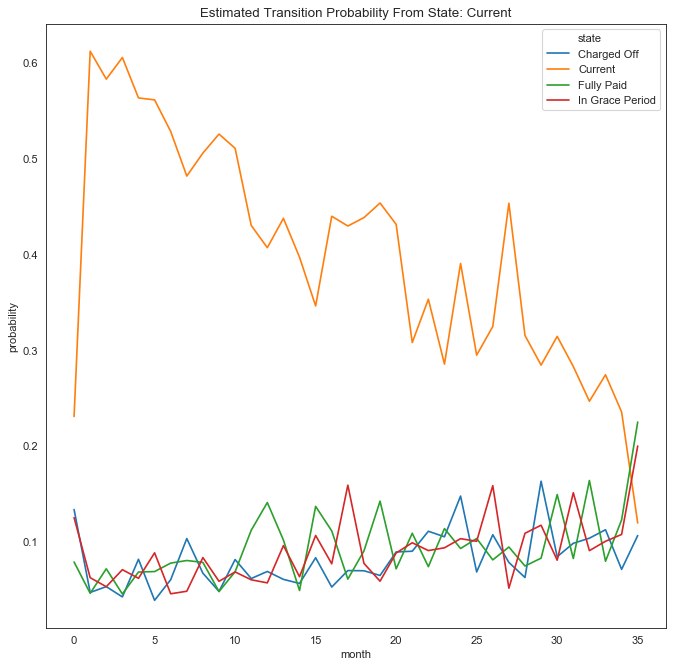

In [32]:
plot_probs_from_state_j(inferred_matrices, 'Current', ['Current', 'In Grace Period', 'Charged Off', 'Fully Paid'])

In the first plot above, we observe transition probabilities over time from the `Current` state to `Charged Off`, `In Grace Period`, `Fully Paid` or back to `Current`. Interestingly, the probability of returning to `Current` descreases over time, which is counter to the intutition we proposed above in the Model section. It is possible that our hypothesis above was simply wrong, and maybe in reality this reflects that it simply gets harder for individuals to stay current on loans as they get deeper into their term.  However, these results could also be a shortcoming of our model, namely, that despite the non-stationarity of the transition matrix, it still doesn't capture the multi-time step, or higher-order, dependencies between the late states, and may overestimate the probability of transitioning to those states while underestimating the probability of staying current as we get deeper into the loan term. 

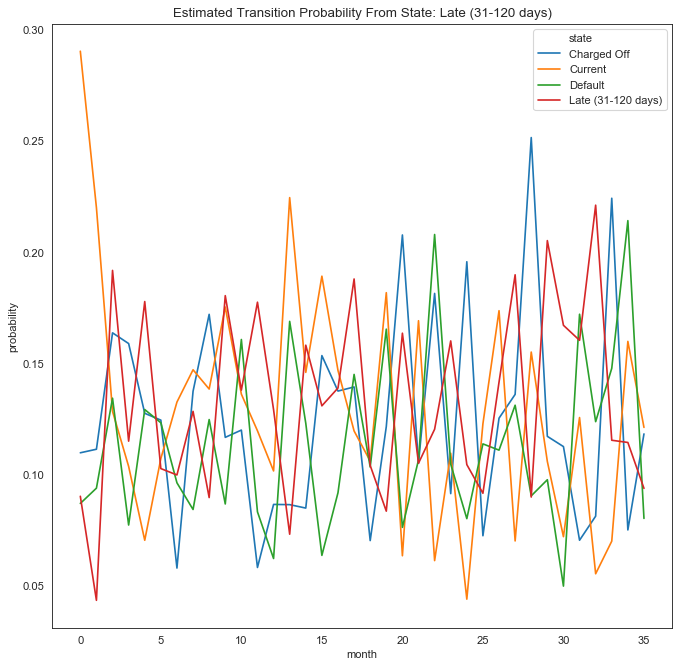

In [20]:
plot_probs_from_state_j(inferred_matrices, 'Late (31-120 days)', ['Current', 'Default', 'Charged Off', 'Late (31-120 days)'])

The second plot above showing transition probabilities from `Late (31-120 day)` to either `Current`, `Default`, `Charged Off` or itself is further evidence for the likely shortcomings of our first-order model, as we would expect the probability of moving into `Charged Off` or `Default` to increase over time (as a loan has been late longer and longer), but our model only knows about the $t-1$ time step and therefore can't capture the higher-order structure, the result being that we really don't see any clear trends in these transition probabilities over time.

## Experiment 5: Modeling counts of transitions, as a multinomial

### 5.1 Model

TODO

In [32]:
pi_list, counts = model_stationary_dirichlet_multinomial(
    n_states, chain_len, total_counts_per_month=x_train.shape[0])

### 5.2 Inference

For now we can just count states globally, but we should write another preprocessing function to count month per month instead (each month is a new drawing of the multinomial). This is mostly for test purposes.

**Pb** we need to add date information when loading the dataframe at the very first...

In [33]:
counts_per_month = get_counts_per_month(x_train, n_states)

Matrix of size (36, 7), total count of statuses per position in the MC.

In [36]:
inferred_matrix, sess, qpi_list = infer_stationary_dirichlet_multinomial(
    counts_per_month, pi_list, counts, x_train.shape[0], n_states, chain_len)

Loading experiment5 data from cache...
Loading cached edward model...
Retrieved 36 rows, 8 columns in 0.39 seconds


In [37]:
round(inferred_matrix, 2)

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
0,0.05,0.65,0.05,0.05,0.05,0.05,0.05,0.05
1,0.05,0.63,0.05,0.06,0.05,0.05,0.05,0.06
2,0.05,0.60,0.05,0.05,0.05,0.05,0.05,0.08
3,0.05,0.59,0.06,0.06,0.05,0.05,0.05,0.09
4,0.05,0.59,0.05,0.05,0.05,0.05,0.05,0.11
5,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.16
6,0.04,0.56,0.04,0.04,0.04,0.05,0.05,0.17
7,0.04,0.53,0.04,0.04,0.05,0.05,0.04,0.20
8,0.04,0.51,0.04,0.04,0.04,0.04,0.04,0.25
9,0.04,0.49,0.04,0.04,0.04,0.04,0.04,0.27


### 5.3 Criticism

TODO

## Conclusions & Future Work

TODO

## References

*Machine Learning: A Probabilistic Perspective*, by Kevin P. Murphy, MIT Press, 2012.

*The Dirichlet-Multinomial and Dirichlet-Categorical models for Bayesian inference*, by Stephen Tu, retrieved from https://people.eecs.berkeley.edu/~stephentu/writeups/dirichlet-conjugate-prior.pdf

*Rubin, Donald B. Bayesianly justifiable and relevant frequency calculations for the applied statistician. The Annals of Statistics, 12(4):1151–1172, 1984.*

*Gelman, Andrew, Meng, Xiao-Li, and Stern, Hal. Posterior predictive assessment of model fitness via realized discrepancies. Statistica Sinica, 6(4):733–760, 1996.*